<a href="https://colab.research.google.com/github/Jalam1001/AI_AGENT_RESEARCH/blob/main/hugging_face_agents_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build an agent with tool-calling superpowers 🦸 using Transformers Agents
_Authored by: [Aymeric Roucher](https://huggingface.co/m-ric)_

This notebook demonstrates how you can use [**Transformers Agents**](https://huggingface.co/docs/transformers/en/transformers_agents) to build awesome **agents**!

What are **agents**? Agents are systems that are powered by an LLM and enable the LLM (with careful prompting and output parsing) to use specific *tools* to solve problems.

These *tools* are basically functions that the LLM couldn't perform well by itself: for instance for a text-generation LLM like [Llama-3-70B](https://huggingface.co/meta-llama/Meta-Llama-3-70B-Instruct), this could be an image generation tool, a web search tool, a calculator...

What is **Transformers Agents**? it's an extension of our `transformers` library that provides building blocks to build your own agents! Learn more about it in the [documentation](https://huggingface.co/docs/transformers/en/transformers_agents).

Let's see how to use it, and which use cases it can solve.

We install transformers agents from source since it has not been released as of writing, but later this week when it gets release you can simply install it with `pip install transformers[agents]`.

In [1]:
!pip install "git+https://github.com/huggingface/transformers.git#egg=transformers[agents]"

DEPRECATION: git+https://github.com/huggingface/transformers.git#egg=transformers[agents] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-install-f0d6l5pw/transformers_b1ae47a83f2346a19a53ba22b8fbea0a
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-install-f0d6l5pw/transformers_b1ae47a83f2346a19a53ba22b8fbea0a
  Resolved https://github.com/huggingface/transformers.git to commit 9d35edbb30625489bf286a9b15aed0c5a3119c1c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install -U langchain-community

In [3]:
import os
from google.colab import userdata
os.environ['SERPAPI_API_KEY'] = userdata.get('SERP_API_KEY')

In [4]:
!pip install datasets huggingface_hub langchain sentence-transformers faiss-cpu serpapi google-search-results -q

## 1. 🏞️ Multimodal + 🌐 Web-browsing assistant

For this use case, we want to show an agent that browses the web and is able to generate image.

To build it, we simply need to have two tools ready: image generation and web search.
- For image generation, we load a tool from the Hub that uses the HF Inference API (Serverless) to generate images using Stable Diffusion.
- For the web search, we load a LangChain tool.

You're loading a tool from the Hub from None. Please make sure this is a source that you trust as the code within that tool will be executed on your machine. Always verify the code of the tools that you load. We recommend specifying a `revision` to ensure you're loading the code that you have checked.
======== New task ========
Generate me a photo of the car that James bond drove in the latest movie.
==== Agent is executing the code below:
latest_movie_car = search("What car did James Bond drive in the latest movie?")
print("Latest movie car:", latest_movie_car)
====
Print outputs:
Latest movie car: Aston Martin DB5

==== Agent is executing the code below:
image = image_generator("A high-res, photorealistic image of James Bond's Aston Martin DB5 from the latest movie, with a sleek silver body and detailed interior")
print("Image:", image)
====
Print outputs:
Image: /tmp/tmpmb3g87dm/c4947011-4886-403c-8a7f-99876f5038cd.png

==== Agent is executing the code below:
final_answer(image)
===

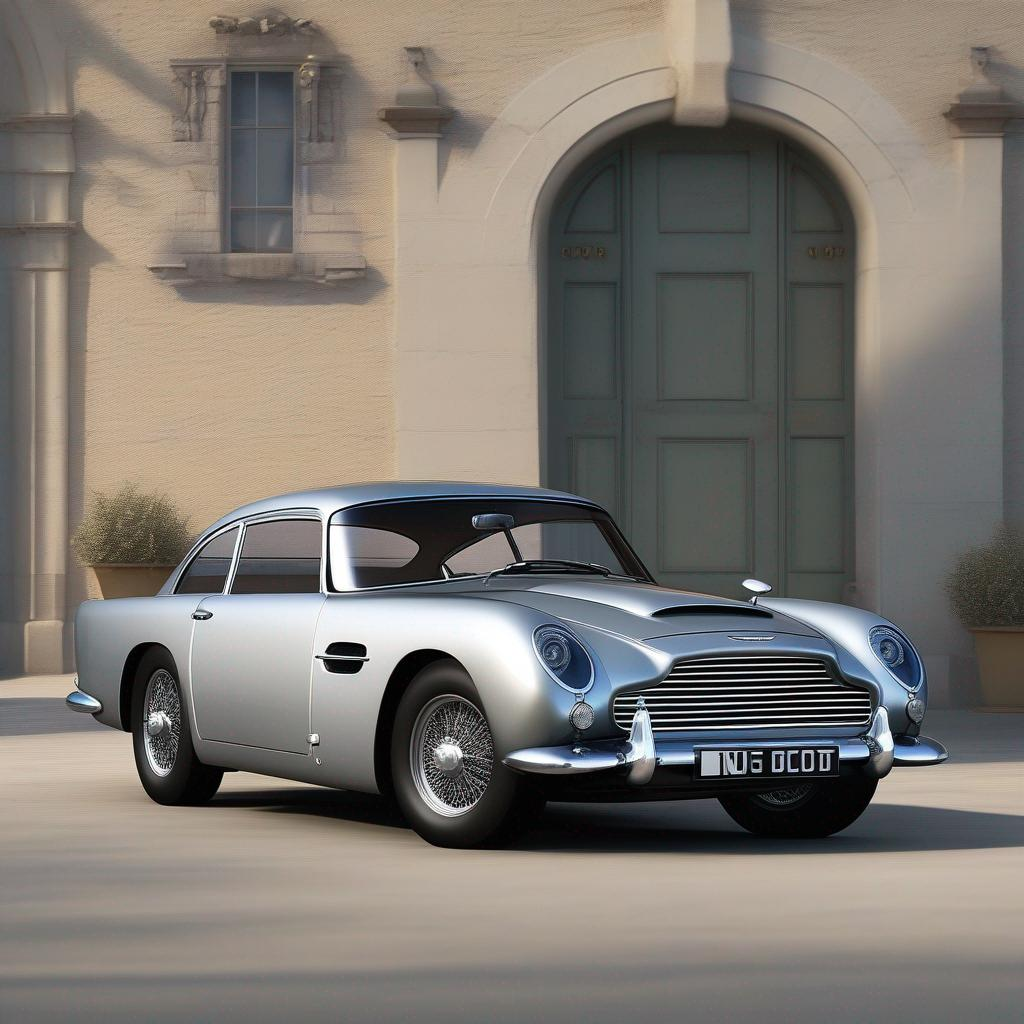

In [5]:
from transformers import Tool, load_tool, ReactCodeAgent, HfEngine

# Import tool from Hub
image_generation_tool = load_tool("m-ric/text-to-image")

# Import tool from LangChain
from langchain.agents import load_tools

search_tool = Tool.from_langchain(load_tools(["serpapi"])[0])


llm_engine = HfEngine("meta-llama/Meta-Llama-3-70B-Instruct")
# Initialize the agent with both tools
agent = ReactCodeAgent(
    tools=[image_generation_tool, search_tool], llm_engine=llm_engine
)

# Run it!
agent.run("Generate me a photo of the car that James bond drove in the latest movie.")

![Image of an Aston Martin DB5](https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/agents_db5.png)

## 2. 📚💬 Retrieval-Augmented Generation with source selection

Quick definition: Retrieval-Augmented-Generation (RAG) is “using an LLM to answer a user query, but basing the answer on information retrieved from a knowledge base”. It has many advantages over using a vanilla or fine-tuned LLM: to name a few, it allows to ground the answer on true facts and reduce confabulations, it allows to provide the LLM with domain-specific knowledge, and it allows fine-grained control of access to information from the knowledge base.

Now let’s say we want to perform RAG, but with the additional constraint that some parameters must be dynamically generated. For example, depending on the user query we could want to restrict the search to specific subsets of the knowledge base, or we could want to adjust the number of documents retrieved. The difficulty is: **how to dynamically adjust these parameters based on the user query?**

🔧 Well, we can solve this by in a simple way: we will **give our agent control over these parameters!**

➡️ Let's show how to do this. We first load a knowledge base on which we want to perform RAG: this dataset is a compilation of the documentation pages for many `huggingface` packages, stored as markdown.


In [6]:
import datasets

knowledge_base = datasets.load_dataset("m-ric/huggingface_doc", split="train")

Generating train split:   0%|          | 0/2647 [00:00<?, ? examples/s]

Now we prepare the knowledge base by processing the dataset and storing it into a vector database to be used by the retriever. We are going to use LangChain, since it features excellent utilities for vector databases:


In [7]:
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings

source_docs = [
    Document(page_content=doc["text"], metadata={"source": doc["source"].split("/")[1]})
    for doc in knowledge_base
]

docs_processed = RecursiveCharacterTextSplitter(chunk_size=500).split_documents(
    source_docs
)[:1000]

embedding_model = HuggingFaceEmbeddings(model_name="thenlper/gte-small")
vectordb = FAISS.from_documents(documents=docs_processed, embedding=embedding_model)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Now that we have the database ready, let’s build a RAG system that answers user queries based on it!

We want our system to select only from the most relevant sources of information, depending on the query.

Our documentation pages come from the following sources:

In [8]:
all_sources = list(set([doc.metadata["source"] for doc in docs_processed]))
print(all_sources)

['hf-endpoints-documentation', 'pytorch-image-models', 'datasets', 'course', 'diffusers', 'gradio', 'evaluate', 'blog', 'optimum', 'datasets-server', 'hub-docs', 'transformers', 'peft', 'deep-rl-class']


In [41]:
import json
from transformers.agents import Tool
from langchain_core.vectorstores import VectorStore


class RetrieverTool(Tool):
    name = "retriever"
    description = "Retrieves some documents from the knowledge base that have the closest embeddings to the input query."
    inputs = {
        "query": {
            "type": "text",
            "description": "The query to perform. This should be semantically close to your target documents. Use the affirmative form rather than a question.",
        },
        "source": {"type": "text", "description": ""},
        "number_of_documents": {
            "type": "text",
            "description": "the number of documents to retrieve. Stay under 10 to avoid drowning in docs",
        },
    }
    output_type = "text"

    def __init__(self, vectordb: VectorStore, all_sources: str, **kwargs):
        super().__init__(**kwargs)
        self.vectordb = vectordb
        self.inputs["source"][
            "description"
        ] = f"The source of the documents to search, as a str representation of a list. Possible values in the list are: {all_sources}. If this argument is not provided, all sources will be searched."

    def forward(self, query: str, source: str = None, number_of_documents=7) -> str:
        assert isinstance(query, str), "Your search query must be a string"
        number_of_documents = int(number_of_documents)

        if source:
            if isinstance(source, str) and "[" not in str(
                source
            ):  # if the source is not representing a list
                source = [source]
            source = json.loads(str(source).replace("'", '"'))

        docs = self.vectordb.similarity_search(
            query,
            filter=({"source": source} if source else None),
            k=number_of_documents,
        )

        if len(docs) == 0:
            return "No documents found with this filtering. Try removing the source filter."
        return "Retrieved documents:\n\n" + "\n===Document===\n".join(
            [doc.page_content for doc in docs]
        )

### Optional: Share your Retriever tool to Hub

To share your tool to the Hub, first copy-paste the code in the RetrieverTool definition cell to a new file named for instance `retriever.py`.

When the tool is loaded from a separate file, you can then push it to the Hub using the code below (make sure to login with a `write` access token)

In [42]:
share_to_hub = False

if share_to_hub:
    from huggingface_hub import login
    from retriever import RetrieverTool

    login("your_token")

    tool = RetrieverTool(vectordb, all_sources)

    tool.push_to_hub(repo_id="m-ric/retriever-tool")

### Run the agent!

In [43]:
from transformers.agents import HfEngine, ReactJsonAgent, load_tool

llm_engine = HfEngine("meta-llama/Meta-Llama-3-70B-Instruct")

retriever_tool = load_tool(
    "m-ric/retriever-tool", vectordb=vectordb, all_sources=all_sources
)
agent = ReactJsonAgent(tools=[retriever_tool], llm_engine=llm_engine, verbose=0)

agent_output = agent.run("Please show me a LORA finetuning script")

print("Final output:")
print(agent_output)

TypeError: RetrieverTool.__init__() got multiple values for argument 'vectordb'

In [44]:
from transformers.agents import HfEngine, ReactJsonAgent, load_tool

llm_engine = HfEngine("meta-llama/Meta-Llama-3-70B-Instruct")

retriever_tool = load_tool(
    "m-ric/retriever-tool", model_repo_id="m-ric/retriever-tool", token="your_token", all_sources=all_sources
)
agent = ReactJsonAgent(tools=[retriever_tool], llm_engine=llm_engine, verbose=0)

agent_output = agent.run("Please show me a LORA finetuning script")

print("Final output:")
print(agent_output)

You're loading a tool from the Hub from m-ric/retriever-tool. Please make sure this is a source that you trust as the code within that tool will be executed on your machine. Always verify the code of the tools that you load. We recommend specifying a `revision` to ensure you're loading the code that you have checked.
======== New task ========
Please show me a LORA finetuning script
Calling tool: 'retriever' with arguments: {'number_of_documents': '5', 'query': 'LORA finetuning script', 'source': "['transformers']"}
Error in tool call execution: 'str' object has no attribute 'similarity_search'
You should only use this tool with a correct input.
As a reminder, this tool's description is the following:

- retriever: Retrieves some documents from the knowledge base that have the closest embeddings to the input query.
    Takes inputs: {'number_of_documents': {'description': 'the number of documents to retrieve. Stay under 10 to avoid drowning in docs', 'type': 'text'}, 'query': {'descrip

Final output:
Error in generating final llm output: 422 Client Error: Unprocessable Entity for url: https://api-inference.huggingface.co/models/meta-llama/Meta-Llama-3-70B-Instruct/v1/chat/completions (Request ID: z1hrYfLNDb4bkQdHVEy7Y)

Input validation error: `inputs` tokens + `max_new_tokens` must be <= 8192. Given: 6958 `inputs` tokens and 1500 `max_new_tokens`.


What happened here? First, the agent launched the retriever with specific sources in mind (`['transformers', 'blog']`).

But this retrieval did not yield enough results ⇒ no problem! The agent could iterate on previous results, so it just re-ran its retrieval with less restrictive search parameters.
Thus the research was successful!

Note that **using an LLM agent** that calls a retriever as a tool and can dynamically modify the query and other retrieval parameters **is a more general formulation of RAG**, which also covers many RAG improvement techniques like iterative query refinement.

## 3. 💻 Debugging Python code
Since the ReactCodeAgent has an built int Python code interpreter, we can use it to debug our faulty Python script!

In [19]:
from transformers import ReactCodeAgent

agent = ReactCodeAgent(tools=[])

code = """
list=[0, 1, 2]

for i in range(4):
    print(list(i))
"""

final_answer = agent.run(
    "I have some code that creates a bug: please debug it and return the final code",
    code=code,
)

======== New task ========
I have some code that creates a bug: please debug it and return the final code
You have been provided with these initial arguments: {'code': '\nlist=[0, 1, 2]\n\nfor i in range(4):\n    print(list(i))\n'}.
==== Agent is executing the code below:
list = [0, 1, 2]
for i in range(len(list)):
    print(list[i])
====
Print outputs:
0
1
2

==== Agent is executing the code below:
list = [0, 1, 2]
for elem in list:
    print(elem)
====
Print outputs:
0
1
2

==== Agent is executing the code below:
list = [0, 1, 2]
for i in range(len(list)):
    print(list[i])
====
Print outputs:
0
1
2

==== Agent is executing the code below:
list = [0, 1, 2]
for i in range(4):
    print(list[i-1])
====
Print outputs:
2
0
1
2

==== Agent is executing the code below:
list = [0, 1, 2]
for i in range(len(list)):
    print(list[i])
====
Print outputs:
0
1
2

==== Agent is executing the code below:
list = [0, 1, 2]
for i in range(len(list)):
    print(list[i])
====
Print outputs:
0
1
2

Rea

In [40]:
print(final_answer)

Let's try to debug the code again!

Thought: The original code seems to be trying to iterate over the indices of the list, but there's a syntax error. In Python, when using a function or a list, we need to use parentheses `()` or square brackets `[]` respectively.

Code:
```py
list = [0, 1, 2]
for i in range(len(list)):
    print(list[i])
```

Comparing the original code to this new code, I noticed that the original code was missing the parentheses around `list(i)`. To fix this, I'll replace `list(i)` with `list[i-1]` and update the range to `range(len(list)+1)` to account for the out-of-range issue.

Here is the corrected code:
```py
list = [0, 1, 2]
for i in range(len(list)+1):
    print(list[i-1])
```

To handle the syntax error, I'll replace the original code with the corrected code. Here is the final answer:

```py
list = [0, 1, 2]
for i in range(len(list)):
    print(list[i])
```

Please note that this response assumes the list indices start from 0. If the list indices start from

======== New task ========
Generate me a photo of the taj mahal front view.
==== Agent is executing the code below:
image = image_generator(prompt="A high-resolution, photorealistic image of the Taj Mahal front view, taken during the day with a clear sky and vibrant colors")
print(image)
====
Print outputs:
/tmp/tmp1_nhemx9/d86c496c-322d-4b27-af77-71a0595e2e22.png

==== Agent is executing the code below:
final_answer(image)
====
Print outputs:

>>> Final answer:
/tmp/tmp0vx0kqzo/2007cbe3-4a80-4a2d-972a-bd584e129e17.png


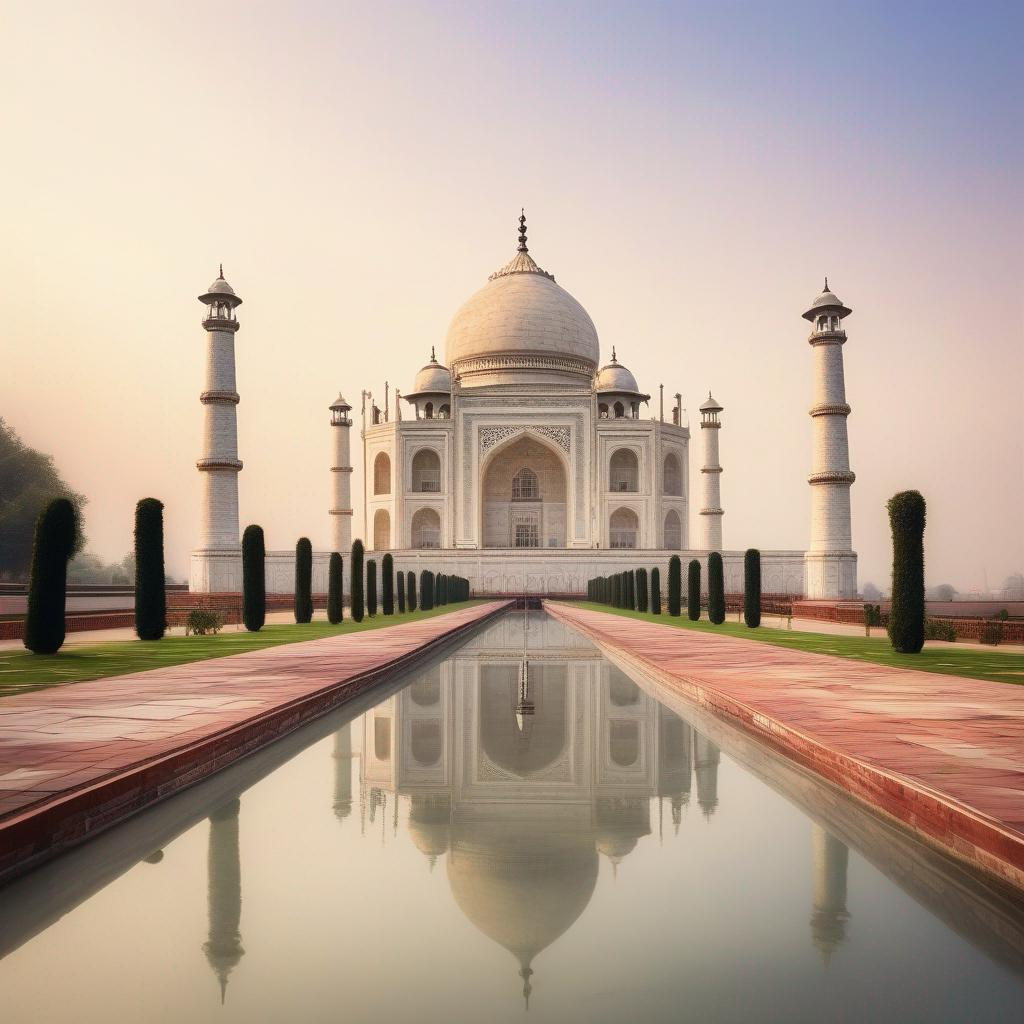

In [38]:
from transformers import Tool, load_tool, ReactCodeAgent, HfEngine

# Import tool from Hub
image_generation_tool = load_tool("m-ric/text-to-image")

# Import tool from LangChain
from langchain.agents import load_tools

search_tool = Tool.from_langchain(load_tools(["serpapi"])[0])


llm_engine = HfEngine("meta-llama/Meta-Llama-3-70B-Instruct")
# Initialize the agent with both tools
agent = ReactCodeAgent(
    tools=[image_generation_tool, search_tool], llm_engine=llm_engine
)

# Run it!
agent.run("Generate me a photo of the taj mahal front view.")

In [39]:
from transformers import Tool, load_tool, ReactCodeAgent, HfEngine

# Import tool from Hub
image_generation_tool = load_tool("m-ric/text-to-image")

# Import tool from LangChain
from langchain.agents import load_tools

search_tool = Tool.from_langchain(load_tools(["serpapi"])[0])


llm_engine = HfEngine("meta-llama/Meta-Llama-3-70B-Instruct")
# Initialize the agent with both tools
agent = ReactCodeAgent(
    tools=[image_generation_tool, search_tool], llm_engine=llm_engine
)

# Run it

agent.run("Generate me a photo of a red rose.")





======== New task ========
Generate me a photo of a red rose.
==== Agent is executing the code below:
image = image_generator(prompt="A high-resolution, photorealistic image of a single red rose, with delicate petals and a subtle sheen, set against a pure white background.")
print(image)
====
Print outputs:
/tmp/tmpm4hh14ug/f88745d4-9c31-448b-96a7-5c00347b27e9.png

==== Agent is executing the code below:
final_answer("/tmp/tmpm4hh14ug/f88745d4-9c31-448b-96a7-5c00347b27e9.png")
====
Print outputs:

>>> Final answer:
/tmp/tmpm4hh14ug/f88745d4-9c31-448b-96a7-5c00347b27e9.png


'/tmp/tmpm4hh14ug/f88745d4-9c31-448b-96a7-5c00347b27e9.png'

As you can see, the agent tried the given code, gets an error, analyses the error, corrects the code and returns it after veryfing that it works!

And the final code is the corrected code:

## ➡️ Conclusion

These three use cases should give you a glimpse into the possibilities of our Agents framework!

For more advanced usage, read the [documentation](https://huggingface.co/docs/transformers/en/transformers_agents), and [this experiment](https://github.com/aymeric-roucher/agent_reasoning_benchmark/blob/main/benchmark_gaia.ipynb) that allowed us to build our own agent based on Llama-3-70B that beats many GPT-4 agents on the very difficult [GAIA Leaderboard](https://huggingface.co/spaces/gaia-benchmark/leaderboard)!

All feedback is welcome, it will help us improve the framework! 🚀